In [1]:
import torch
import pyro
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import os
from cities.utils.data_grabber import find_repo_root
from cities.utils.data_loader import ZoningDataset
from cities.modeling.evaluation import prep_data_for_test, test_performance

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel


import matplotlib.pyplot as plt
import seaborn as sns

root = find_repo_root()

[iteration 0001] loss: 491.5534
[iteration 0050] loss: 399.3978
[iteration 0100] loss: 372.5830
[iteration 0150] loss: 360.7816
[iteration 0200] loss: 346.9753
[iteration 0250] loss: 343.0284
[iteration 0300] loss: 340.6369
[iteration 0350] loss: 343.3617
[iteration 0400] loss: 340.2755
[iteration 0450] loss: 341.0744
[iteration 0500] loss: 338.5584
[iteration 0550] loss: 342.4129
[iteration 0600] loss: 340.9622


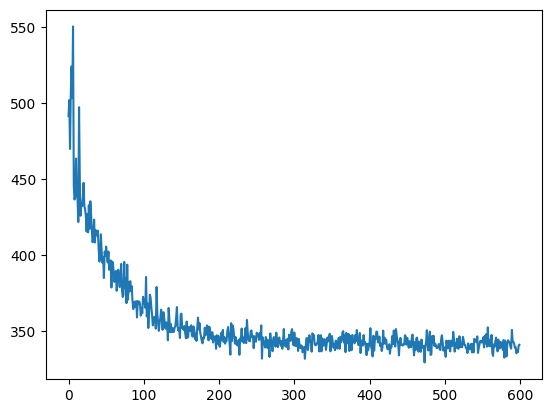

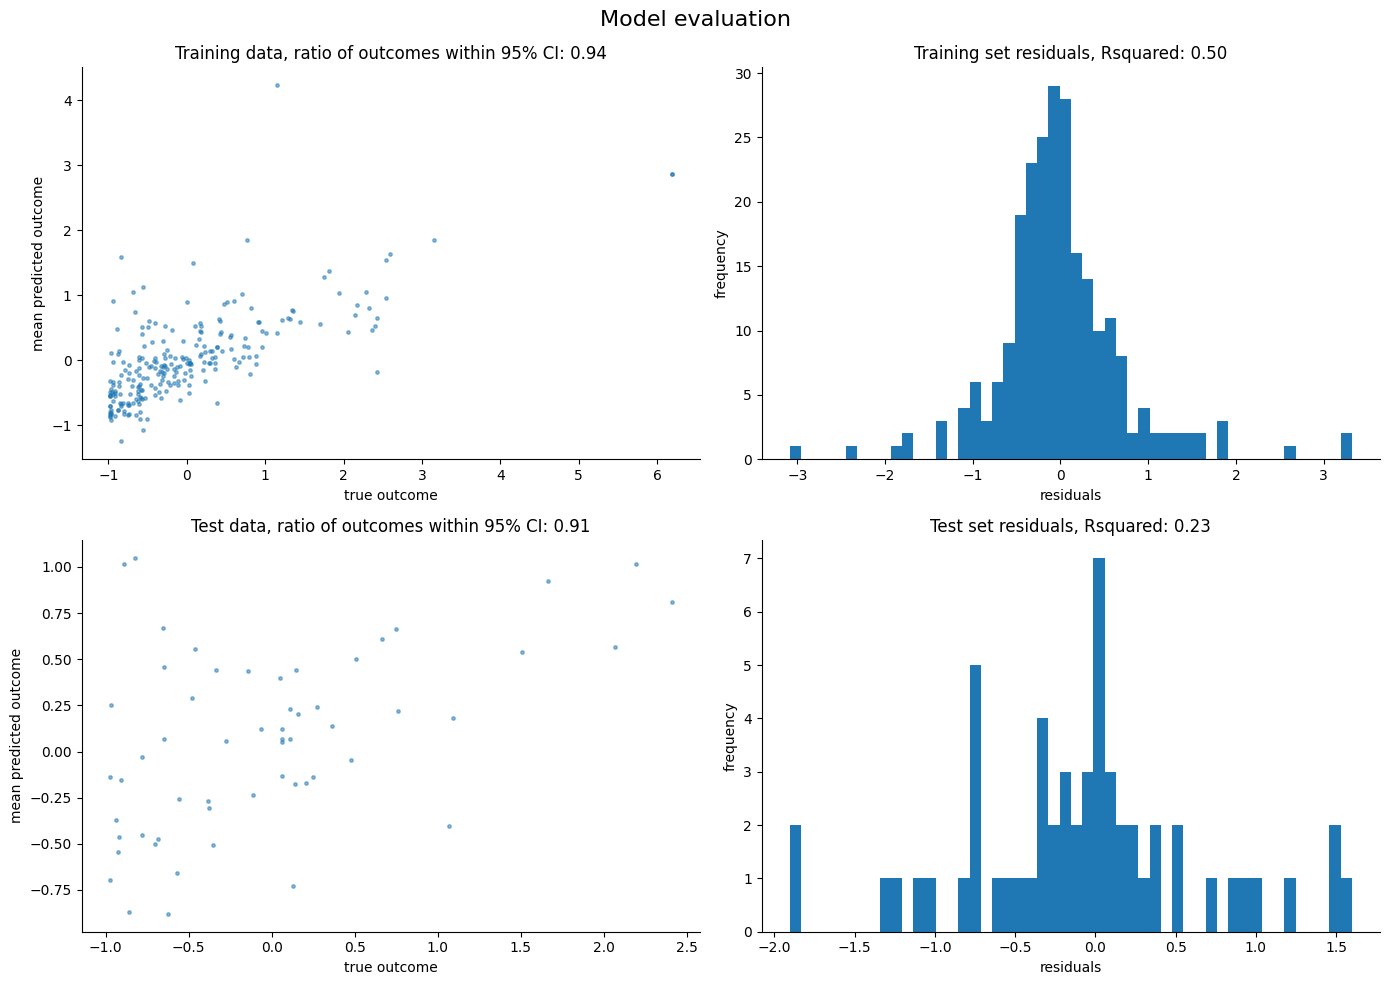

{'mae_train': 0.49137401580810547,
 'mae_test': 0.5366582274436951,
 'rsquared_train': tensor(0.4989),
 'rsquared_test': tensor(0.2255),
 'coverage_train': 0.9419087171554565,
 'coverage_test': 0.9122806787490845}

In [2]:
train_loader, test_loader, categorical_levels = prep_data_for_test(train_size = .8)

kwarg_names = {"categorical": ['limit_id', 'neighborhood_id'],
              "continuous": {'parcel_area'}, "outcome": 'housing_units'}

test_performance(SimpleLinear, kwarg_names, train_loader,
                  test_loader, categorical_levels, plot = True)